# 5.SQL and Dataframes

References:

* Spark-SQL, <https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes>


# 5.1  Example Walkthrough
Follow the Spark SQL and Dataframes Examples below!

### Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
# Initialize PySpark
APP_NAME = "PySpark Lecture Herget"
SPARK_MASTER="spark://mpp3r01c03s03.cos.lrz.de:7077"

def initSC(cores):
    # If there is no SparkSession, create the environment
    try:
        sc and spark
    except NameError as e:
      #import findspark
      #findspark.init()
        import pyspark
        import pyspark.sql
        from pyspark.sql import Row
        conf=pyspark.SparkConf().setAppName(APP_NAME+" "+cores+" CORES").set("spark.cores.max", cores)
        sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
        spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME+" "+cores+" CORES").getOrCreate()
    print("PySpark initiated... (cores: "+cores+")")
    return sc, spark

def reinitSC(cores, sc):
    import pyspark
    import pyspark.sql    
    sc.stop()
    
    # make config changes and restart
    conf=pyspark.SparkConf().setAppName(APP_NAME+" "+cores+" CORES").set("spark.cores.max", cores)
    sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
    #spark = pyspark.sql.SparkSession(sc).builder \
     #   .appName(APP_NAME+" "+cores+" CORES") \
      #  .config('spark.cores.max', cores) \
       # .getOrCreate() 
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME+" "+cores+" CORES").getOrCreate()
    #sc = spark.sparkContext    
    print("PySpark reinitiated... (cores: "+cores+")")
    return sc, spark

sc, spark = initSC('16')

from pyspark.sql import Row
def nasa_split_http(line):
    parts = line.split(' ')
    if (len(parts) > 2):
        row = Row(
            ip=parts[0],
            http_response=parts[-2],
        )
        return row
    else:
        return {}

def nasafileprep():
    nasa = sc.textFile("../data/nasa/NASA_access_log_Jul95")
    nasa_rows = nasa.flatMap(lambda line: line.split('\n')).map(nasa_split_http)
    # Convert to a pyspark.sql.DataFrame
    nasa_rows_df = nasa_rows.toDF()

    # Register the DataFrame for Spark SQL
    nasa_rows_df.registerTempTable("ip_response")
    return nasa_rows_df

PySpark initiated... (cores: 16)


### Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [3]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

PySpark reinitiated... (cores: 1)


[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

### Creating Rows

Creating `pyspark.sql.Rows` out of your data so you can create DataFrames...

In [3]:
# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
    parts = line.split(",")
    row = Row(
      name=parts[0],
      company=parts[1],
      title=parts[2]
    )
    return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)

### Creating DataFrames from RDDs

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [4]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()

# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[Row(name='Donald Trump', total=1),
 Row(name='Florian Liebert', total=1),
 Row(name='Don Brown', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Steve Jobs', total=1)]

# 5.2-5.9 NASA DataSet

5.2 Create a Spark-SQL table with fields for IP/Host and Response Code from the NASA Log file! 

In [ ]:
#199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245
#row = Row(
#    ip=parts[0],
#    date=parts[3]+' '+parts[4],
#    http_method=parts[5].replace('\"', ''),
#    http_url=parts[6],
#    http_version=parts[7].replace('"',''),
#    http_response=parts[8],
#    response_time=parts[9]
#)

In [4]:
nasa_rows_df = nasafileprep()
# Generate a new DataFrame with SQL using the SparkSession
job_show = spark.sql("""
SELECT
  *
  FROM ip_response
""")
job_show.show()

# Go back to an RDD
#job_show.rdd.collect()

+-------------+--------------------+
|http_response|                  ip|
+-------------+--------------------+
|          200|        199.72.81.55|
|          200|unicomp6.unicomp.net|
|          200|      199.120.110.21|
|          304|  burger.letters.com|
|          200|      199.120.110.21|
|          304|  burger.letters.com|
|          200|  burger.letters.com|
|          200|     205.212.115.106|
|          200|         d104.aa.net|
|          200|      129.94.144.152|
|          200|unicomp6.unicomp.net|
|          200|unicomp6.unicomp.net|
|          200|unicomp6.unicomp.net|
|          200|         d104.aa.net|
|          200|         d104.aa.net|
|          200|         d104.aa.net|
|          304|      129.94.144.152|
|          200|      199.120.110.21|
|          200|ppptky391.asahi-n...|
|          200|  net-1-141.eden.com|
+-------------+--------------------+
only showing top 20 rows



5.3 Run an SQL query that outputs the number of occurrences of each HTTP response code!

In [3]:
# Generate a new DataFrame with SQL using the SparkSession
job_show_53 = spark.sql("""
SELECT
  http_response, count(http_response)
  FROM ip_response
  GROUP BY http_response
""")
job_show_53.show()
 
# Go back to an RDD
job_show_53.rdd.collect()

+-------------+--------------------+
|http_response|count(http_response)|
+-------------+--------------------+
|          200|             1701534|
|         null|                   0|
|          302|               46573|
|          501|                  14|
|          404|               10845|
|          403|                  54|
|          500|                  62|
|          304|              132627|
|          400|                   5|
+-------------+--------------------+



[Row(http_response='200', count(http_response)=1701534),
 Row(http_response=None, count(http_response)=0),
 Row(http_response='302', count(http_response)=46573),
 Row(http_response='501', count(http_response)=14),
 Row(http_response='404', count(http_response)=10845),
 Row(http_response='403', count(http_response)=54),
 Row(http_response='500', count(http_response)=62),
 Row(http_response='304', count(http_response)=132627),
 Row(http_response='400', count(http_response)=5)]

5.4 Cachen Sie den Dataframe und führen Sie dieselbe Query nochmals aus! Messen Sie die Laufzeit für das Cachen und für die Ausführungszeit der Query!

In [3]:
import time
nasa_rows_df.cache()

start = time.time()
nasa_rows_df.cache()
end = time.time()
print("Cache time: ",end - start)

start = time.time()
job_show_53 = spark.sql("""
SELECT
  http_response, count(http_response)
  FROM ip_response
  GROUP BY http_response
""")
job_show_53.show()
end = time.time()
print("Query time (uncached): ",end - start)

start = time.time()
job_show_53 = spark.sql("""
SELECT
  http_response, count(http_response)
  FROM ip_response
  GROUP BY http_response
""")
job_show_53.show()
end = time.time()
print("Query time cached: ",end - start)
nasa_rows_df.cache().unpersist()

Cache time:  0.01969146728515625
+-------------+--------------------+
|http_response|count(http_response)|
+-------------+--------------------+
|          200|             1701534|
|         null|                   0|
|          302|               46573|
|          501|                  14|
|          404|               10845|
|          403|                  54|
|          500|                  62|
|          304|              132627|
|          400|                   5|
+-------------+--------------------+

Query time (uncached):  43.43684935569763
+-------------+--------------------+
|http_response|count(http_response)|
+-------------+--------------------+
|          200|             1701534|
|         null|                   0|
|          302|               46573|
|          501|                  14|
|          404|               10845|
|          403|                  54|
|          500|                  62|
|          304|              132627|
|          400|                   5|

DataFrame[http_response: string, ip: string]

5.5. Implement the same Query using the Dataframe API!

5.6 Führen Sie diesselbe Query mit/ohne Cache und 8, 16 Cores aus! Dokumentieren und erklären Sie das Ergebnis!

In [4]:
import time
cors = [1]
cachs = [True, False]
result = []
for cor in cors:
    # Init Cores
    sc, spark = reinitSC(str(cor), sc)
    print(sc._conf.getAll())
    for cach in cachs:
        nasa_rows_df = nasafileprep()
        if cach:
            # Init Cache
            print("   Init cache")
            nasa_rows_df.cache()
            start = time.time()
            job_show_53 = spark.sql("""
            SELECT
              http_response, count(http_response)
              FROM ip_response
              GROUP BY http_response
            """)
            job_show_53.show()
            end = time.time()
            print("      Query time (uncached): ",end - start)
        # Do benchmark
        print("    Starting benchmark")
        bstart = time.time()
        job_show_53 = spark.sql("""
        SELECT
          http_response, count(http_response)
          FROM ip_response
          GROUP BY http_response
        """)
        job_show_53.show()
        bend = time.time()
        print("      Query time (cores: "+str(cor)+", cached: "+str(cach)+"): ",bend - bstart)
        result.append({'cores': cor, 'cached': cach, 'time': bend - bstart})
        if cach:
            nasa_rows_df.cache().unpersist()
print(result)

PySpark reinitiated... (cores: 1)
[('spark.cores.max', '1'), ('spark.app.id', 'app-20180406134454-0101'), ('spark.master', 'spark://mpp3r01c03s03.cos.lrz.de:7077'), ('spark.app.name', 'PySpark Lecture Herget 1 CORES'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.driver.port', '38446'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.host', 'mpp3r01c03s02-op')]
   Init cache
+-------------+--------------------+
|http_response|count(http_response)|
+-------------+--------------------+
|          200|             1701534|
|         null|                   0|
|          302|               46573|
|          501|                  14|
|          404|               10845|
|          403|                  54|
|          500|                  62|
|          304|              132627|
|          400|                   5|
+-------------+--------------------+

      Query time 

Result:
% [{'cores': 16, 'cached': True, 'time': 2.846684455871582}, {'cores': 16, 'cached': False, 'time': 28.683916091918945}, {'cores': 8, 'cached': True, 'time': 4.1324403285980225}, {'cores': 8, 'cached': False, 'time': 24.340951204299927}]
[{'cores': 1, 'cached': True, 'time': 23.264286756515503}, {'cores': 1, 'cached': False, 'time': 147.1105170249939}]

| Cores | Cached | Measured time|
|---|---|---|
| 1     | no     | 147.1105 |
| 1     | yes    | 23.2642|
| 8     | no     | 24.3409|
| 8     | yes    | 4.1324|
| 16    | no     | 28.6839|
| 16    | yes    | 2.8466 |

5.7 Performance Analysis: 
* Create RDDs with 2x, 4x, 8x and 16x of the size of the NASA log dataset! Persist the dataset in the Spark Cache! Use an appropriate number of cores (e.g. 8 or 16)!
* Measure and plot the response times for all datasets using a constant number of cores!
* Plot the results!
* Explain the results!



In [5]:
import time
result = []
core='8'
sc, spark = reinitSC(core, sc)
size = [1, 2, 4, 8, 16]
for siz in size: 
    print("Prepare file for size: ",siz)
    nasa = sc.textFile("../data/nasa/NASA_access_log_Jul95")
    for i in range(0, siz-1): 
        nasa_un = nasa.union(nasa)
    if siz == 1:
        nasa_un = nasa
    nasa_rows = nasa_un.flatMap(lambda line: line.split('\n')).map(nasa_split_http)
    nasa_rows_df = nasa_rows.toDF()
    nasa_rows_df.registerTempTable("ip_response")
    
    print("   Init cache")
    nasa_rows_df.cache()
    start = time.time()
    job_show_53 = spark.sql("""
    SELECT
      http_response, count(http_response)
      FROM ip_response
      GROUP BY http_response
    """)
    job_show_53.show()
    end = time.time()
    print("      Query time (uncached): ",end - start)
    
    print("    Starting benchmark")
    bstart = time.time()
    job_show_53 = spark.sql("""
    SELECT
      http_response, count(http_response)
      FROM ip_response
      GROUP BY http_response
    """)
    job_show_53.show()
    bend = time.time()
    print("      Query time (cores: "+core+", size: "+str(siz)+"): ",bend - bstart)
    result.append({'cores': core, 'size': siz, 'time': bend - bstart})

pyplot_result_57 = result
print(result)

PySpark reinitiated... (cores: 8)
Prepare file for size:  1
   Init cache
+-------------+--------------------+
|http_response|count(http_response)|
+-------------+--------------------+
|          200|             1701534|
|         null|                   0|
|          302|               46573|
|          501|                  14|
|          404|               10845|
|          403|                  54|
|          500|                  62|
|          304|              132627|
|          400|                   5|
+-------------+--------------------+

      Query time (uncached):  40.36943292617798
    Starting benchmark
+-------------+--------------------+
|http_response|count(http_response)|
+-------------+--------------------+
|          200|             1701534|
|         null|                   0|
|          302|               46573|
|          501|                  14|
|          404|               10845|
|          403|                  54|
|          500|                  62|
|  

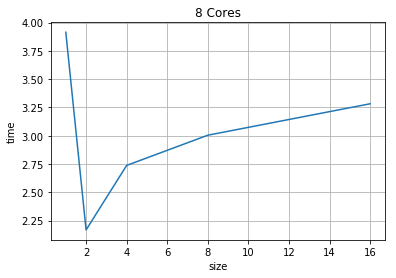

In [7]:
import numpy as np
import matplotlib.pyplot as plt
x=[]
y=[]
for res in pyplot_result_57:
    y.append(res['time'])
    x.append(res['size'])
plt.plot(x,y)
plt.xlabel('size')
plt.ylabel('time')
plt.title(pyplot_result_57[0]['cores']+' Cores')
plt.grid(True)

5.8 Strong Scaling

  * Measure the runtime for the query for 8, 16, 32, 64, 128, 256 cores for 1x and 16x datasets! Datasets cached in Memory!
  * Compute the speedup and efficiency!
  * Plot the responses!
  * Explain the results!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import operator
data_performance = np.genfromtxt('./performance-05.csv', skip_header=1, delimiter=',', names=['scale', 'cores', 'time'])
print(len(data_performance))
fig = plt.figure()
cores={}
sizes={}
for data in data_performance:
    if int(data['cores']) not in cores:
        cores[int(data['cores'])] = []
    if int(data['scale']) not in sizes:
        sizes[int(data['scale'])] = []
    cores[int(data['cores'])].append({'scale': int(data['scale']), 'time': data['time']})
    sizes[int(data['scale'])].append({'cores': int(data['cores']), 'time': data['time']})

# simple plots
for core in cores:
    x=[]
    y=[]
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for res in cores[core]:
        y.append(res['time'])
        x.append(res['scale'])
    ax1.set_title(str(core)+' Cores')    
    ax1.set_xlabel('Scale')
    ax1.set_ylabel('Time')
    ax1.plot(x,y, 'g^')

for size in sizes:
    x=[]
    y=[]
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for res in sizes[size]:
        y.append(res['time'])
        x.append(res['cores'])
    ax1.set_title(str(size)+'x Scale')    
    ax1.set_xlabel('Cores')
    ax1.set_ylabel('Time')
    ax1.plot(x,y, 'g^')

# Speeup & Efficency
avgtime={}
for core in cores:
    scales={}
    scales_num={}
    # sum times
    for scale in cores[core]:
        if int(scale['scale']) not in scales:
            scales[int(scale['scale'])] = scale['time']
            scales_num[int(scale['scale'])] = 1
        else:
            scales[int(scale['scale'])] += scale['time']
            scales_num[int(scale['scale'])] += 1
    # Calc avg time 
    res = {}
    for scale in scales:
        res[scale] = scales[scale]/scales_num[scale]
    avgtime[core] = res

speedup={}
efficency={}
for core in avgtime:
    if core != 1:
        res={}
        resef={}
        for scale in avgtime[core]:
            res[scale] = avgtime[1][scale]/avgtime[core][scale]
            resef[scale] = res[scale]/core
        speedup[core]=res
        efficency[core]=resef

for core in speedup:
    print ("Cores: "+str(core))
    for scale in speedup[core]:
        print("  "+str(scale)+"x Scale:\n    "+str(speedup[core][scale])+" Speedup\n    "+str(efficency[core][scale])+" Efficency")

80
Cores: 2
  16x Scale:
    2.202630938319914 Speedup
    1.101315469159957 Efficency
  1x Scale:
    1.7398220087582992 Speedup
    0.8699110043791496 Efficency
  8x Scale:
    1.9407439513320228 Speedup
    0.9703719756660114 Efficency
Cores: 4
  16x Scale:
    4.716412147421666 Speedup
    1.1791030368554165 Efficency
  1x Scale:
    2.98256405288904 Speedup
    0.74564101322226 Efficency
  8x Scale:
    3.423648279628618 Speedup
    0.8559120699071545 Efficency
Cores: 8
  16x Scale:
    7.163685414345199 Speedup
    0.8954606767931499 Efficency
  1x Scale:
    3.454560753954898 Speedup
    0.43182009424436224 Efficency
  8x Scale:
    4.221488939021516 Speedup
    0.5276861173776894 Efficency


5.9 Convert the output to a Pandas dataframe and calculate the percentage of total for each response code!

do not need
